In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
import pyarrow.feather as pyfa
os.chdir('/home/sambeet/data/dsg/')

In [2]:
trade = pyfa.read_feather('trade_custmod_bond_market.feather',nthreads=8)
test = pyfa.read_feather('test_custmod_bond_market.feather',nthreads=8)

In [3]:
trade.columns

Index([u'CustomerIdx', u'IsinIdx', u'BuySell', u'year', u'weekofyear',
       u'CustomerInterest', u'predCustomerInterest', u'ZSpread_mean_lag1',
       u'Price_mean_lag1', u'Yield_mean_lag1', u'ZSpread_mean_lag2',
       u'Price_mean_lag2', u'Yield_mean_lag2', u'ZSpread_mean_lag3',
       u'Price_mean_lag3', u'Yield_mean_lag3', u'IsinIdx_count',
       u'IsinIdx_nunique', u'NotionalEUR_mean', u'Price_mean',
       u'Buy_Transactions', u'Sell_Transactions', u'Tenure', u'Vintage',
       u'BondMaturingDays_mean', u'BondAgeDays_mean', u'BondDuration_mean',
       u'IssuedAmount_mean', u'Rating_0_Count', u'Rating_1_Count',
       u'Rating_2_Count', u'Rating_3_Count', u'Rating_4_Count',
       u'CouponType_Step_Count', u'CouponType_Floating_Count',
       u'CouponType_Zero_Count', u'CouponType_Variable_Count',
       u'CouponType_None_Count', u'CustomerRegion', u'IssuedAmount',
       u'MaturityPeriod'],
      dtype='object')

In [4]:
categorical_holdings = ['BuySell','year','CustomerRegion']
predictors_holdings = list(trade.columns)
predictors_holdings.remove('CustomerInterest')
predictors_holdings.remove('CustomerIdx')
predictors_holdings.remove('IsinIdx')
predictors_holdings.remove('weekofyear')
target_holdings = 'CustomerInterest'

In [6]:
print(predictors_holdings)

[u'BuySell', u'year', u'predCustomerInterest', u'ZSpread_mean_lag1', u'Price_mean_lag1', u'Yield_mean_lag1', u'ZSpread_mean_lag2', u'Price_mean_lag2', u'Yield_mean_lag2', u'ZSpread_mean_lag3', u'Price_mean_lag3', u'Yield_mean_lag3', u'IsinIdx_count', u'IsinIdx_nunique', u'NotionalEUR_mean', u'Price_mean', u'Buy_Transactions', u'Sell_Transactions', u'Tenure', u'Vintage', u'BondMaturingDays_mean', u'BondAgeDays_mean', u'BondDuration_mean', u'IssuedAmount_mean', u'Rating_0_Count', u'Rating_1_Count', u'Rating_2_Count', u'Rating_3_Count', u'Rating_4_Count', u'CouponType_Step_Count', u'CouponType_Floating_Count', u'CouponType_Zero_Count', u'CouponType_Variable_Count', u'CouponType_None_Count', u'CustomerRegion', u'IssuedAmount', u'MaturityPeriod']


In [13]:
rounds = 10000
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 31,
#    'max_depth': 3,
    'learning_rate' : 0.1,
#    'feature_fraction' : 0.5,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : 1,
    'num_threads' : 8,
#    'min_data_in_leaf' : 10000,
#    'lambda_l1' : 1,
#    'lambda_l2' : 1,
#    'cat_smooth' : 50,
#    'max_bin' : 50,
    'scale_pos_weight' : 10
}

In [18]:
#train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.2, random_state=37)
kf = KFold(n_splits=5,shuffle=True,random_state=37)
kf.get_n_splits(trade)
for i, (train_index, test_index) in zip(range(1,6),kf.split(trade)):
    if i == 1:
        X_train = trade.loc[train_index,predictors_holdings].values
        X_test = trade.loc[test_index,predictors_holdings].values
        y_train = trade.loc[train_index,target_holdings].values
        y_test = trade.loc[test_index,target_holdings].values
        X_train = lgb.Dataset(X_train,y_train,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
        X_test = lgb.Dataset(X_test,y_test,feature_name=predictors_holdings,categorical_feature = categorical_holdings)
        gc.collect()
        print 'Starting training on fold:',i
        model = lgb.train(lgbm_params,X_train,num_boost_round=rounds,valid_sets=[X_test],valid_names=['valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=100)
        test['CustomerInterest_' + str(i)] = model.predict(test.loc[:,predictors_holdings].values)

Starting training on fold: 1
Training until validation scores don't improve for 50 rounds.
[100]	valid's auc: 0.845923
[200]	valid's auc: 0.848431
[300]	valid's auc: 0.850027
[400]	valid's auc: 0.851178
[500]	valid's auc: 0.8522
[600]	valid's auc: 0.853001
[700]	valid's auc: 0.853633
[800]	valid's auc: 0.854241
[900]	valid's auc: 0.854636
[1000]	valid's auc: 0.855014
[1100]	valid's auc: 0.855467
[1200]	valid's auc: 0.855836
[1300]	valid's auc: 0.856153
[1400]	valid's auc: 0.856438
[1500]	valid's auc: 0.856662
[1600]	valid's auc: 0.85692
[1700]	valid's auc: 0.857171
[1800]	valid's auc: 0.857427
[1900]	valid's auc: 0.857619
[2000]	valid's auc: 0.857761
[2100]	valid's auc: 0.857938
[2200]	valid's auc: 0.858102
[2300]	valid's auc: 0.858265
[2400]	valid's auc: 0.858445
[2500]	valid's auc: 0.858551
[2600]	valid's auc: 0.858678
[2700]	valid's auc: 0.858817
[2800]	valid's auc: 0.858938
[2900]	valid's auc: 0.859073
[3000]	valid's auc: 0.85918
[3100]	valid's auc: 0.859274
[3200]	valid's auc: 0.8

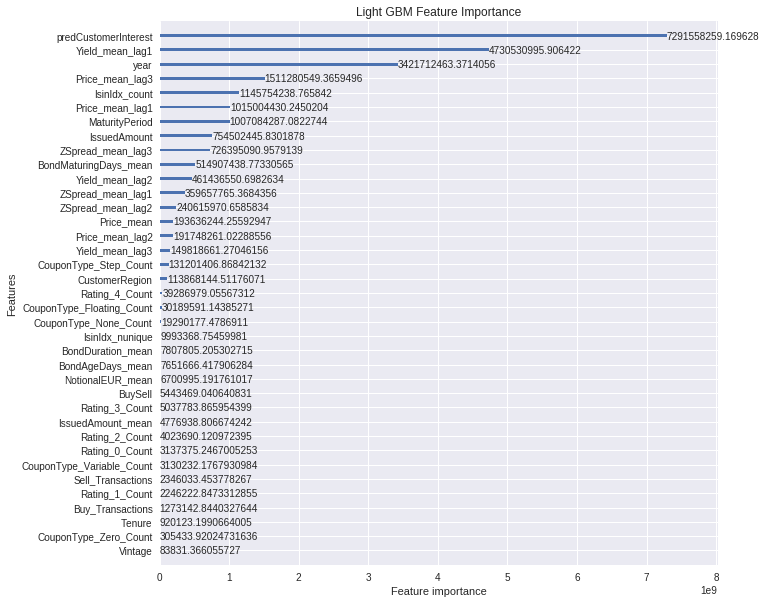

In [10]:
lgb.plot_importance(model,importance_type='gain',figsize=(10,10))
plt.title("Light GBM Feature Importance")

test['CustomerInterest_1'] = test.CustomerInterest_1.rank(pct=True)
test['CustomerInterest_2'] = test.CustomerInterest_2.rank(pct=True)
test['CustomerInterest_3'] = test.CustomerInterest_3.rank(pct=True)
test['CustomerInterest_4'] = test.CustomerInterest_4.rank(pct=True)
test['CustomerInterest_5'] = test.CustomerInterest_5.rank(pct=True)

In [11]:
test['CustomerInterest'] = (test.CustomerInterest_1)# + test.CustomerInterest_2 + test.CustomerInterest_3 + test.CustomerInterest_4 + test.CustomerInterest_5)/5.

In [12]:
test[['PredictionIdx','CustomerInterest']].to_csv('sub_sam_lgb_3.csv',index=False)

import catboost as cb
cat_features_index = [0,1]

'''
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(train, y_train)
'''
#With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=255,depth=3, iterations= 100, l2_leaf_reg= 9, learning_rate= 0.01)
clf.fit(trade.loc[train_index,predictors],trade.loc[train_index,target], cat_features= cat_features_index,
       eval_set=(trade.loc[valid_index,predictors],trade.loc[valid_index,target]),plot=True)

#Create valid
filtered = trade[(trade.year == 2018) & (trade.weekofyear >= 13) & (trade.CustomerInterest == True)].reset_index(drop=True)
filtered = filtered.drop_duplicates()
#filtered = filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear']]
filtered_sell = filtered[['CustomerIdx','IsinIdx']].drop_duplicates()
filtered_buy = filtered_sell.copy()
filtered_sell['BuySell'] = 1
filtered_buy['BuySell'] = 0
filtered_valid_1 = pd.concat([filtered_sell,filtered_buy],axis=0)
filtered_valid_1['year'] = 2018.
filtered_valid_1['weekofyear'] = 13
filtered_valid_2 = filtered_valid_1.copy()
filtered_valid_2['weekofyear'] = 14
filtered_valid_3 = filtered_valid_1.copy()
filtered_valid_3['weekofyear'] = 15
filtered_valid_4 = filtered_valid_1.copy()
filtered_valid_4['weekofyear'] = 16
filtered_valid = pd.concat([filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4],axis=0)
del filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4,filtered_buy,filtered_sell
gc.collect()
filtered_valid = filtered_valid.merge(filtered,on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
filtered_valid['CustomerInterest'][filtered_valid.CustomerInterest.isnull()] = 0
filtered_valid.head()

filtered_valid['predCustomerInterest'] = model.predict(filtered_valid.loc[:,predictors].values)
filtered_valid['predCustomerInterest'][filtered_valid.BuySell == 0] = 1 - filtered_valid['predCustomerInterest'][filtered_valid.BuySell == 0]

from sklearn.metrics import roc_auc_score
y_true = filtered_valid.CustomerInterest.astype(int).values
y_scores = filtered_valid.predCustomerInterest.values
roc_auc_score(y_true, y_scores)